# Import Packages

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import numpy as np
import scipy.special as sp
from scipy.optimize import curve_fit
import uproot # uproot examples: https://indico.cern.ch/event/686641/contributions/2894906/attachments/1606247/2548596/pivarski-uproot.pdf

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.loc'] = 'upper right'
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['font.family'] = 'serif'

colors = ['#1f78b4', '#e66101', '#33a02c', '#984ea3', '#F27781', '#18298C', '#04BF8A', '#F2CF1D', '#F29F05', '#7155D9', 
          '#8D07F6', '#9E91F2', '#F29B9B', '#F25764', '#6FB7BF', '#B6ECF2', '#5D1314', '#B3640F']

# Define Event Quality Cuts

In [4]:
def GetCut(tree, DNN='SS', DNN_Val=0.85):
    if DNN=='SS': 
        cut = np.where((tree['passed_xy_thresh'].array() == True) \
                & (tree['passed_z_thresh'].array() == True) \
                & (tree['n_x_ch_abovenoise'].array() > 0) \
                & (tree['n_y_ch_abovenoise'].array() > 0) \
                & (tree['m_nOPCal'].array() < (1.077*tree['m_nQ'].array()+313)) \
                & (tree['m_nOPCal'].array() > (0.597*tree['m_nQ'].array()-216)) \
                & (tree['standoff'].array() > 20) \
                & (tree['m_DNNvalue'].array() > DNN_Val) \
                & (tree['energy'].array() > 2000) \
                & (tree['energy'].array() < 3000) \
                & (tree['NESTBugFound'].array() == False) \
                & (tree['NearAnodeBugFound'].array() == False) \
                )
    elif DNN=='MS': 
        cut = np.where((tree['passed_xy_thresh'].array() == True) \
                & (tree['passed_z_thresh'].array() == True) \
                & (tree['n_x_ch_abovenoise'].array() > 0) \
                & (tree['n_y_ch_abovenoise'].array() > 0) \
                & (tree['m_nOPCal'].array() < (1.077*tree['m_nQ'].array()+313)) \
                & (tree['m_nOPCal'].array() > (0.597*tree['m_nQ'].array()-216)) \
                & (tree['standoff'].array() > 20) \
                & (tree['m_DNNvalue'].array() < DNN_Val) \
                & (tree['energy'].array() > 2000) \
                & (tree['energy'].array() < 3000) \
                & (tree['NESTBugFound'].array() == False) \
                & (tree['NearAnodeBugFound'].array() == False) \
                )
    elif DNN=='ALL': 
        cut = np.where((tree['passed_xy_thresh'].array() == True) \
                & (tree['passed_z_thresh'].array() == True) \
                & (tree['n_x_ch_abovenoise'].array() > 0) \
                & (tree['n_y_ch_abovenoise'].array() > 0) \
                & (tree['m_nOPCal'].array() < (1.077*tree['m_nQ'].array()+313)) \
                & (tree['m_nOPCal'].array() > (0.597*tree['m_nQ'].array()-216)) \
                & (tree['standoff'].array() > 20) \
                & (tree['m_DNNvalue'].array() > 0) \
                & (tree['energy'].array() > 2000) \
                & (tree['energy'].array() < 3000) \
                & (tree['NESTBugFound'].array() == False) \
                & (tree['NearAnodeBugFound'].array() == False) \
                )
    return cut         

# Define Fit Functions

In [5]:
def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

In [6]:
def gaus_erfc(x,a,x0,sigma,z,b):
    return a*np.exp(-(x-x0)**2/(2*sigma**2)) + a*sp.erf(z)+b

# Get Merged Trees

In [7]:
bb0n = uproot.open("/p/vast1/nexo/data/merged-v10b/Baseline2019_bb0n_FullLXe.root")['tree']

In [8]:
th232 = uproot.open("/p/vast1/nexo/data/merged-v10b/Baseline2019_Th232_TPCVessel.root")['tree']

In [9]:
u238 = uproot.open("/p/vast1/nexo/data/merged-v10b/Baseline2019_U238_TPCVessel.root")['tree']

# Get Quality Cuts for each Tree

In [10]:
bb0n_cut = GetCut(bb0n, DNN='ALL')

In [11]:
th232_cut = GetCut(th232, DNN='ALL')

In [12]:
u238_cut = GetCut(u238, DNN='ALL')

# Define Function to select events within a certain Z-slice

In [13]:
def GetEventsInZ(Tree, QCut, Zmin, Zmax, Zvariable='lower_z'):
    ThisTreeZ = Tree[Zvariable].array()[QCut]
    CutZ = np.where((ThisTreeZ > Zmin) & (ThisTreeZ < Zmax))
    return Tree['energy'].array()[QCut][CutZ]

# Selecting events in Z-slices and fitting them

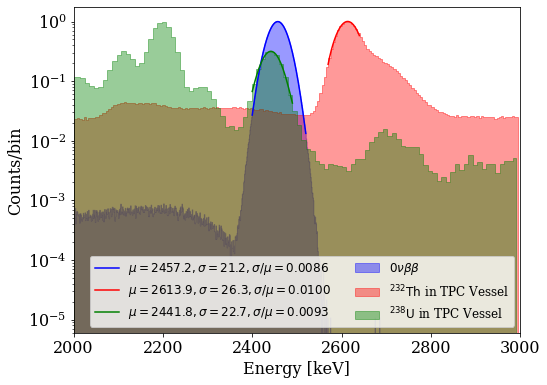

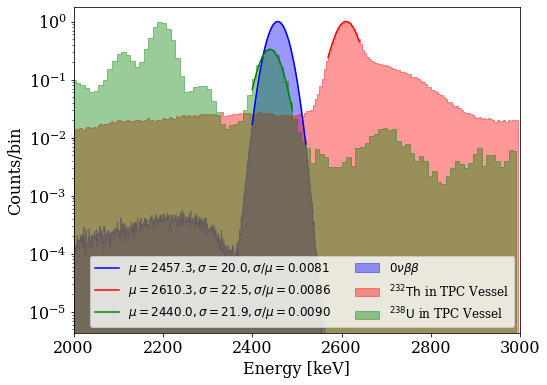

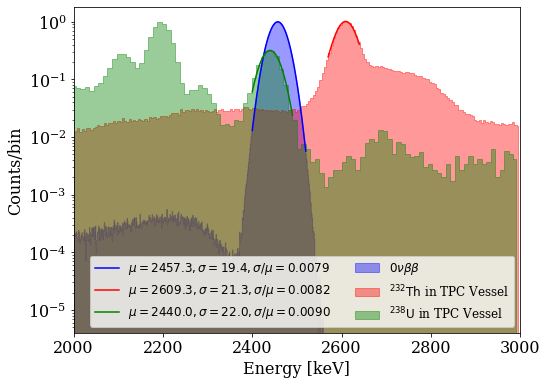

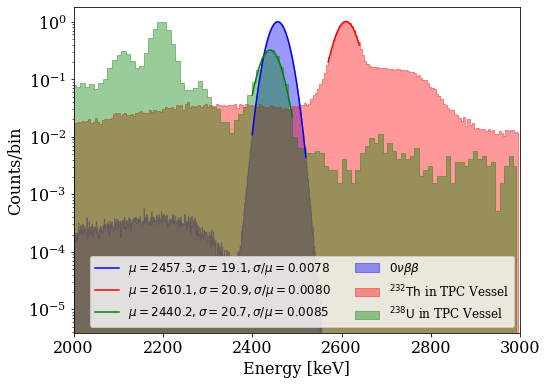

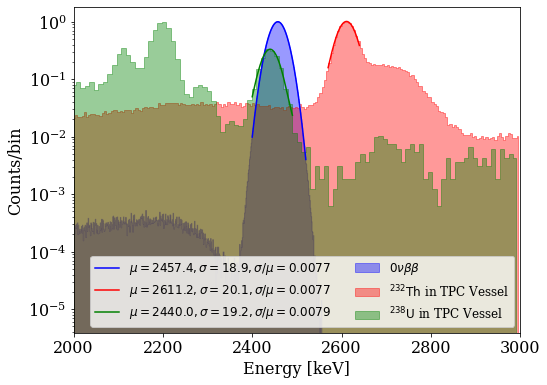

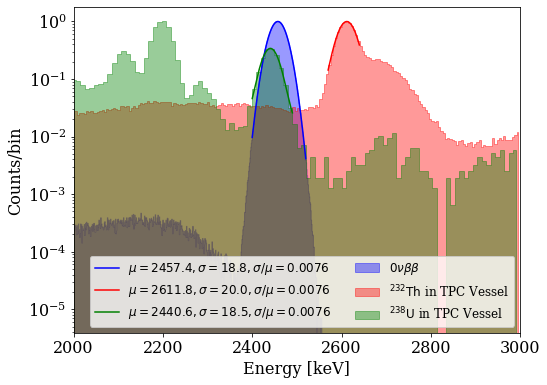

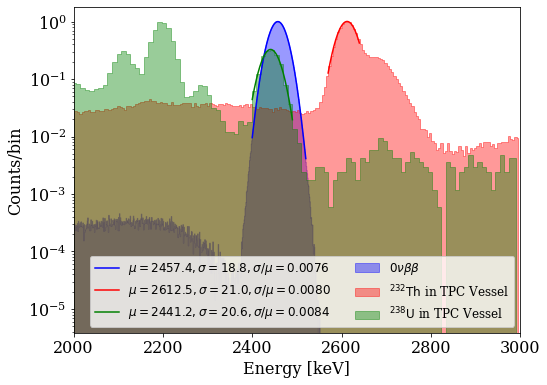

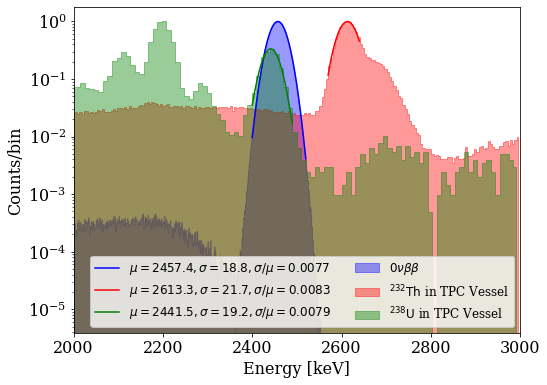

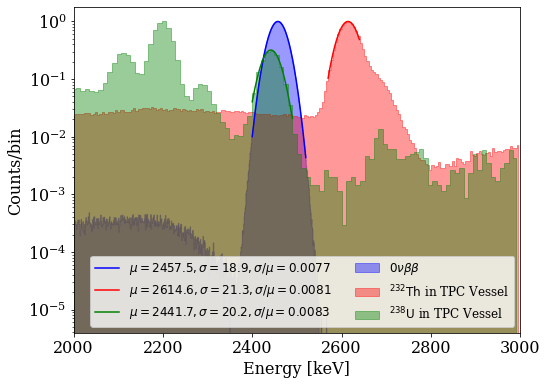

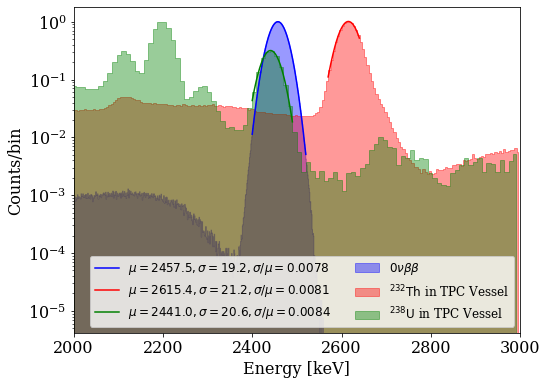

In [14]:
ZSlices = np.linspace(-1560, -420, 11)[::-1]
res_bb0n = []
res_th232 = []
res_u238 = []
for ii,Z in enumerate(ZSlices[:-1]): 
    
    events_bb0n = GetEventsInZ(Tree=bb0n, QCut=bb0n_cut, Zmin=ZSlices[ii+1], Zmax=ZSlices[ii], Zvariable='lower_z')
    events_th232 = GetEventsInZ(Tree=th232, QCut=th232_cut, Zmin=ZSlices[ii+1], Zmax=ZSlices[ii], Zvariable='lower_z')
    events_u238 = GetEventsInZ(Tree=u238, QCut=u238_cut, Zmin=ZSlices[ii+1], Zmax=ZSlices[ii], Zvariable='lower_z')
    
    h1,hx1 = np.histogram(events_bb0n, bins=np.linspace(2000,3000,1000))
    h2,hx2 = np.histogram(events_th232, bins=np.linspace(2000,3000,200))
    h3,hx3 = np.histogram(events_u238, bins=np.linspace(2000,3000,100))
    
    X1 = [2400.0, 2520.0]
    X2 = [2570.0, 2640.0]
    X3 = [2400.0, 2490.0]
    
    Cut1 = np.where((hx1>X1[0]) & (hx1<X1[1]))
    Cut2 = np.where((hx2>X2[0]) & (hx2<X2[1]))
    Cut3 = np.where((hx3>X3[0]) & (hx3<X3[1]))

    popt1, pcov1 = curve_fit(gaus_erfc, hx1[Cut1], (h1/np.max(h1))[Cut1], p0=[1,2458,20,1,0])
    popt2, pcov2 = curve_fit(gaus_erfc, hx2[Cut2], (h2/np.max(h2))[Cut2], p0=[1,2620,20,1,0])
    popt3, pcov3 = curve_fit(gaus_erfc, hx3[Cut3], (h3/np.max(h3))[Cut3], p0=[1,2448,20,1,0], bounds=([0,2440,16,0,0], [1,2450,100,10000,10000]) )

    fig, ax = plt.subplots(figsize=(8, 6))
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('Energy [keV]', fontsize=16)
    plt.ylabel('Counts/bin', fontsize=16)
    
    plt.fill_between(hx1[:-1], h1/np.max(h1), label=r'$0\nu\beta\beta$', step="mid", alpha=0.4, color='b')
    plt.fill_between(hx2[:-1], h2/np.max(h2), label=r'$^{232}\mathrm{Th}$ in TPC Vessel', step="mid", alpha=0.4, color='r')
    plt.fill_between(hx3[:-1], h3/np.max(h3), label=r'$^{238}\mathrm{U}$ in TPC Vessel', step="mid", alpha=0.4, color='g')
    
    plt.plot(np.linspace(X1[0],X1[1],500), gaus_erfc(np.linspace(X1[0],X1[1],500), *popt1), lw=1.5, label = r'$\mu=%.1f, \sigma=%.1f, \sigma/\mu=%.4f$' % (popt1[1], popt1[2], popt1[2]/popt1[1]), color='b')
    plt.plot(np.linspace(X2[0],X2[1],500), gaus_erfc(np.linspace(X2[0],X2[1],500), *popt2), lw=1.5, label = r'$\mu=%.1f, \sigma=%.1f, \sigma/\mu=%.4f$' % (popt2[1], popt2[2], popt2[2]/popt2[1]), color='r')
    plt.plot(np.linspace(X3[0],X3[1],500), gaus_erfc(np.linspace(X3[0],X3[1],500), *popt3), lw=1.5, label = r'$\mu=%.1f, \sigma=%.1f, \sigma/\mu=%.4f$' % (popt3[1], popt3[2], popt3[2]/popt3[1]), color='g')

    res_bb0n.append(popt1[2]/popt1[1])
    res_th232.append(popt2[2]/popt2[1])
    res_u238.append(popt3[2]/popt3[1])

    plt.legend(loc='lower right', ncol=2)
    plt.xlim(2000,3000)
    plt.yscale('log')

    plt.savefig('plots/energy_res/energy_res_zslice_%d.png' % ii, dpi=600, bbox_inches='tight')

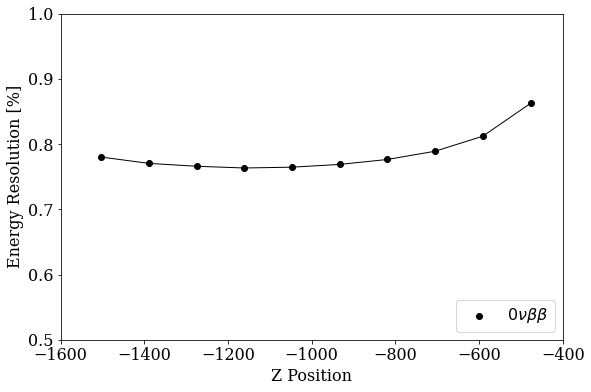

In [15]:
fig, ax = plt.subplots(figsize=(9, 6))
plt.xticks(fontsize=16)
plt.yticks(np.arange(0.5,1.1,0.1),fontsize=16)
plt.xlabel('Z Position', fontsize=16)
plt.ylabel('Energy Resolution [%]', fontsize=16)

plt.plot(ZSlices[:-1] + np.diff(ZSlices)[0]/2, np.array(res_bb0n)*100, label='', color='k')
plt.scatter(ZSlices[:-1] + np.diff(ZSlices)[0]/2, np.array(res_bb0n)*100, label=r'$0\nu\beta\beta$', color='k')

plt.xlim(-1600,-400)
plt.ylim(0.5,1)
plt.legend(loc='lower right', fontsize=16)
plt.savefig('plots/energy_res/energy_vs_z.png', dpi=600, bbox_inches='tight')

# Fit entire dataset to get average energy resolution

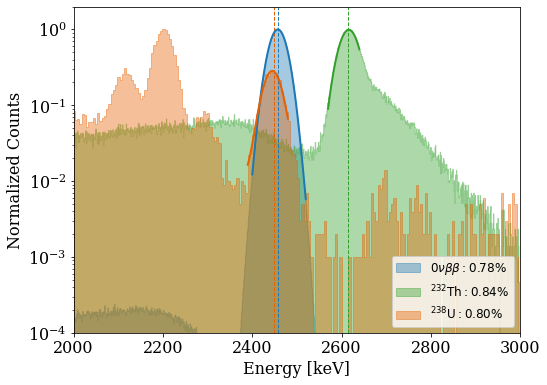

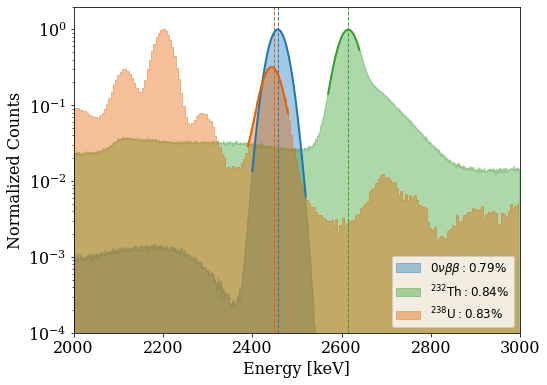

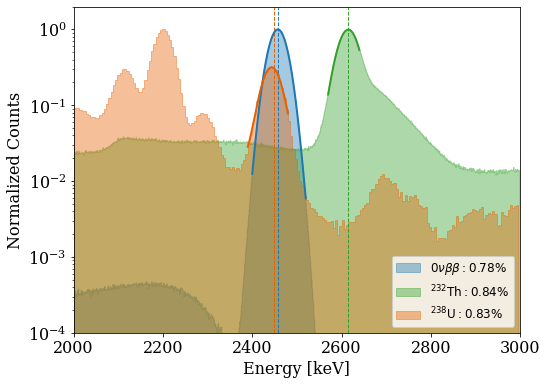

In [16]:
for DNN in ['SS', 'MS', 'ALL']: 
# for DNN in ['SS']: 
    bb0n_cut = GetCut(tree=bb0n, DNN=DNN)
    th232_cut = GetCut(tree=th232, DNN=DNN)
    u238_cut = GetCut(tree=u238, DNN=DNN)

    h4,hx4 = np.histogram(bb0n['energy'].array()[bb0n_cut], bins=np.linspace(2000,3000,1000))
    h5,hx5 = np.histogram(th232['energy'].array()[th232_cut], bins=np.linspace(2000,3000,1000))
    h6,hx6 = np.histogram(u238['energy'].array()[u238_cut], bins=np.linspace(2000,3000,200))

    X4 = [2400.0, 2520.0]
    X5 = [2570.0, 2640.0]
    X6 = [2390.0, 2480.0]

    Cut4 = np.where((hx4>X4[0]) & (hx4<X4[1]))
    Cut5 = np.where((hx5>X5[0]) & (hx5<X5[1]))
    Cut6 = np.where((hx6>X6[0]) & (hx6<X6[1]))

    popt4, pcov4 = curve_fit(gaus_erfc, hx4[Cut4], (h4/np.max(h4))[Cut4], p0=[1,2458,20,1,0])
    popt5, pcov5 = curve_fit(gaus_erfc, hx5[Cut5], (h5/np.max(h5))[Cut5], p0=[1,2620,20,1,0])
    popt6, pcov6 = curve_fit(gaus_erfc, hx6[Cut6], (h6/np.max(h6))[Cut6], p0=[1,2458,20,1,0])

    fig, ax = plt.subplots(figsize=(8, 6))
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('Energy [keV]', fontsize=16)
    plt.ylabel('Normalized Counts', fontsize=16)

    plt.fill_between(hx4[:-1], h4/np.max(h4), label=r'$0\nu\beta\beta$' + '$:{:0.2f}\%$'.format(popt4[2]/popt4[1]*100), step="mid", alpha=0.4, color=colors[0])
    plt.axvline(2458, ymax=1, ls='--', color=colors[0])

    plt.fill_between(hx5[:-1], h5/np.max(h5), label=r'$^{232}\mathrm{Th}$' + '$:{:0.2f}\%$'.format(popt5[2]/popt5[1]*100), step="mid", alpha=0.4, color=colors[2])
    plt.axvline(2614, ymax=1, ls='--', color=colors[2])

    plt.fill_between(hx6[:-1], h6/np.max(h6), label=r'$^{238}\mathrm{U}$' + '$:{:0.2f}\%$'.format(popt6[2]/popt6[1]*100), step="mid", alpha=0.4, color=colors[1])
    plt.axvline(2448, ymax=1, ls='--', color=colors[1])

    plt.plot(np.linspace(X4[0],X4[1],500), gaus_erfc(np.linspace(X4[0],X4[1],500), *popt4), lw=2.0, label = '', color=colors[0])
    plt.plot(np.linspace(X5[0],X5[1],500), gaus_erfc(np.linspace(X5[0],X5[1],500), *popt5), lw=2.0, label = '', color=colors[2])
    plt.plot(np.linspace(X6[0],X6[1],500), gaus_erfc(np.linspace(X6[0],X6[1],500), *popt6), lw=2.0, label = '', color=colors[1])

    # plt.plot(np.linspace(X4[0],X4[1],500), gaus_erfc(np.linspace(X4[0],X4[1],500), *popt4), lw=2.0, label = '$\sigma/\mu={:0.2f}\%$'.format(popt4[2]/popt4[1]*100), color=colors[0])
    # plt.plot(np.linspace(X5[0],X5[1],500), gaus_erfc(np.linspace(X5[0],X5[1],500), *popt5), lw=2.0, label = '$\sigma/\mu={:0.2f}\%$'.format(popt5[2]/popt5[1]*100), color=colors[1])
    # plt.plot(np.linspace(X6[0],X6[1],500), gaus_erfc(np.linspace(X6[0],X6[1],500), *popt6), lw=2.0, label = '$\sigma/\mu={:0.2f}\%$'.format(popt6[2]/popt6[1]*100), color=colors[2])

    plt.legend(loc='lower right', ncol=1)
    plt.xlim(2000,3000)
    plt.ylim(1e-4,2E0)
    plt.yscale('log')

    plt.savefig('plots/energy_res/energy_res_all_{}.png'.format(DNN), dpi=600, bbox_inches='tight')